In [42]:
import pandas as pd
import glob
import re

meta_file = "AIDA_Phase1_second_level1.csv"
meta = pd.read_csv(meta_file, sep=';', dtype=str)
meta = meta[meta["Annotation_Level_1"].isin(["B", "Plasma B"])]
meta["barcode_clean"] = meta["barcode_name"].str.replace(r"^B[0-9]+_L[0-9]+_", "", regex=True)

bcr_files = glob.glob("filtered_contig_annotations_B*_L*.csv")

def read_and_format_bcr(file):
    df = pd.read_csv(file, dtype=str)
    match = re.search(r"filtered_contig_annotations_(B[0-9]+_L[0-9]+)\.csv", file)
    suffix = match.group(1) if match else ""
    suffix = re.sub(r"L(\d)$", r"L00\1", suffix)
    df["barcode"] = df["barcode"] + "-" + suffix
    df["barcode"] = df["barcode"].str.replace("-1-", "-RU_", regex=False)
    df["sample"] = suffix
    return df

bcr_list = [read_and_format_bcr(file) for file in bcr_files]
combined_bcr = pd.concat(bcr_list, ignore_index=True)

# мердж с метаданными
combined_df = pd.merge(
    combined_bcr,
    meta[["barcode_clean", "Genotyping_ID", "ethnicity", "age", "T2D", "sex", "Annotation_Level_1", "Annotation_Level_2"]],
    left_on="barcode",
    right_on="barcode_clean",
    how="left"
)

# фильтрация клеток с минимум 2 цепями
filtered_df = combined_df.groupby("barcode").filter(lambda x: len(x) >= 2)

# Удаление донора 8897 
filtered_df = filtered_df[filtered_df["Genotyping_ID"] != "8897"].copy()
filtered_df["Group"] = filtered_df["T2D"].apply(lambda x: "T2D" if x == "1" else "Control")


Уникальных B-клеток (barcode): 52039


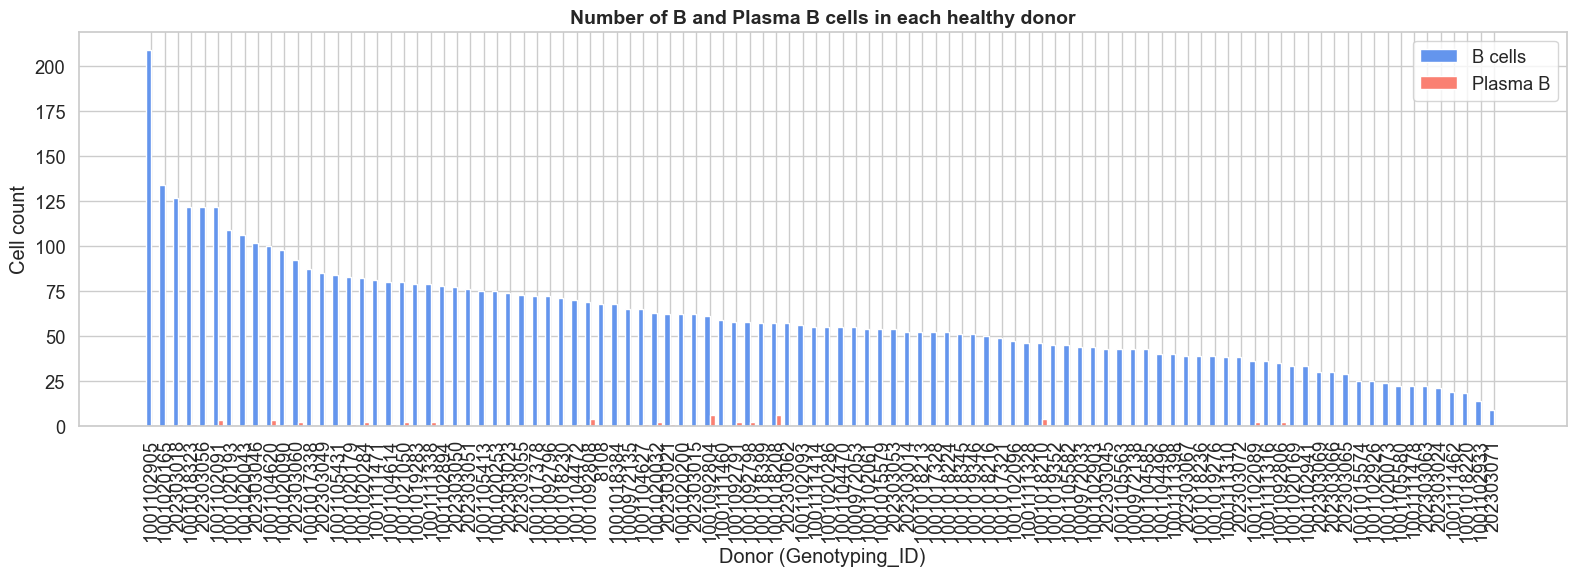

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

healthy_df = filtered_df[filtered_df["T2D"] == "0"].copy()

b_cells = healthy_df[healthy_df["Annotation_Level_1"] == "B"].groupby("Genotyping_ID")["barcode"].nunique().reset_index()
b_cells.columns = ["Genotyping_ID", "B_cells"]

plasma_cells = healthy_df[healthy_df["Annotation_Level_1"] == "Plasma B"].groupby("Genotyping_ID")["barcode"].nunique().reset_index()
plasma_cells.columns = ["Genotyping_ID", "Plasma_B_cells"]

cell_counts = pd.merge(b_cells, plasma_cells, on="Genotyping_ID", how="outer").fillna(0)
cell_counts = cell_counts.sort_values(by="B_cells", ascending=False)

x = np.arange(len(cell_counts))  
width = 0.4

plt.figure(figsize=(16, 6))
plt.bar(x - width/2, cell_counts["B_cells"], width=width, label="B cells", color="cornflowerblue")
plt.bar(x + width/2, cell_counts["Plasma_B_cells"], width=width, label="Plasma B", color="salmon")

plt.xticks(ticks=x, labels=cell_counts["Genotyping_ID"], rotation=90)
plt.xlabel("Donor (Genotyping_ID)")
plt.ylabel("Cell count")
plt.title("Number of B and Plasma B cells in each healthy donor", fontsize=14, weight="bold")
plt.legend()
plt.tight_layout()
plt.show()


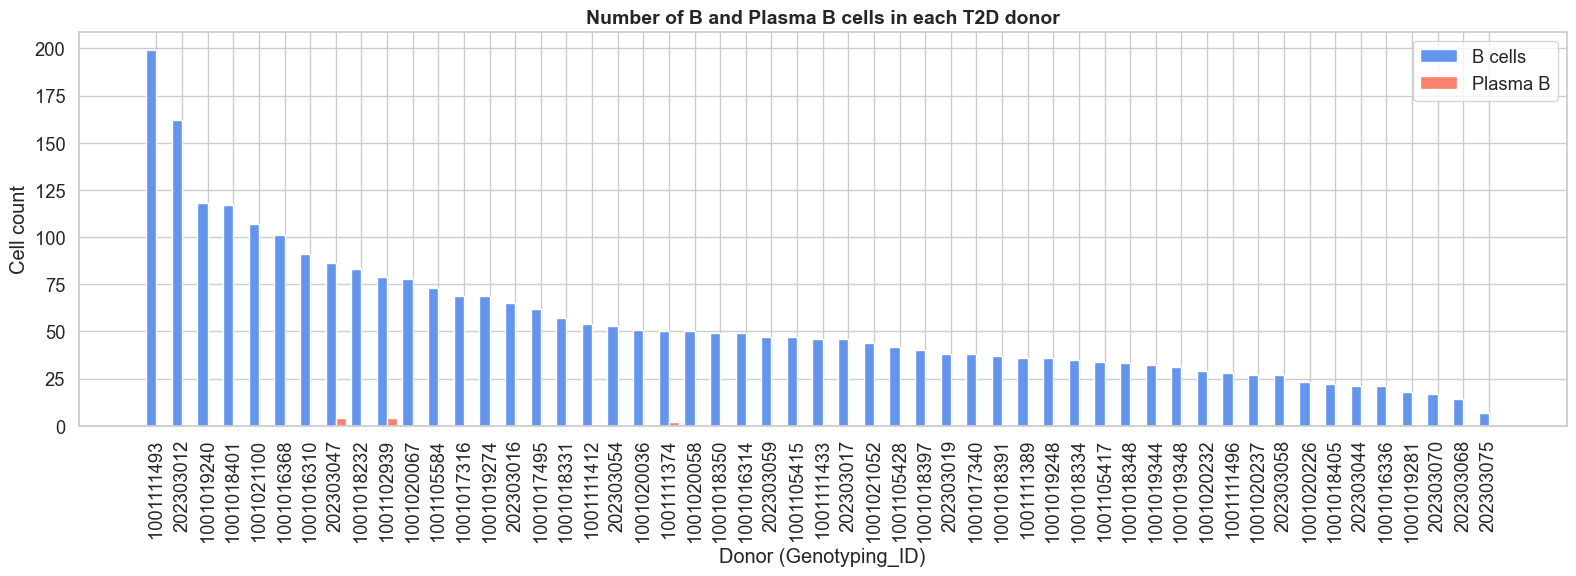

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

t2d_df = filtered_df[filtered_df["T2D"] == "1"].copy()

b_cells = t2d_df[t2d_df["Annotation_Level_1"] == "B"].groupby("Genotyping_ID")["barcode"].nunique().reset_index()
b_cells.columns = ["Genotyping_ID", "B_cells"]

plasma_cells = t2d_df[t2d_df["Annotation_Level_1"] == "Plasma B"].groupby("Genotyping_ID")["barcode"].nunique().reset_index()
plasma_cells.columns = ["Genotyping_ID", "Plasma_B_cells"]
cell_counts = pd.merge(b_cells, plasma_cells, on="Genotyping_ID", how="outer").fillna(0)
cell_counts = cell_counts.sort_values(by="B_cells", ascending=False)


x = np.arange(len(cell_counts)) 
width = 0.4

plt.figure(figsize=(16, 6))
plt.bar(x - width/2, cell_counts["B_cells"], width=width, label="B cells", color="cornflowerblue")
plt.bar(x + width/2, cell_counts["Plasma_B_cells"], width=width, label="Plasma B", color="salmon")

plt.xticks(ticks=x, labels=cell_counts["Genotyping_ID"], rotation=90)
plt.xlabel("Donor (Genotyping_ID)")
plt.ylabel("Cell count")
plt.title("Number of B and Plasma B cells in each T2D donor", fontsize=14, weight="bold")
plt.legend()
plt.tight_layout()
plt.show()


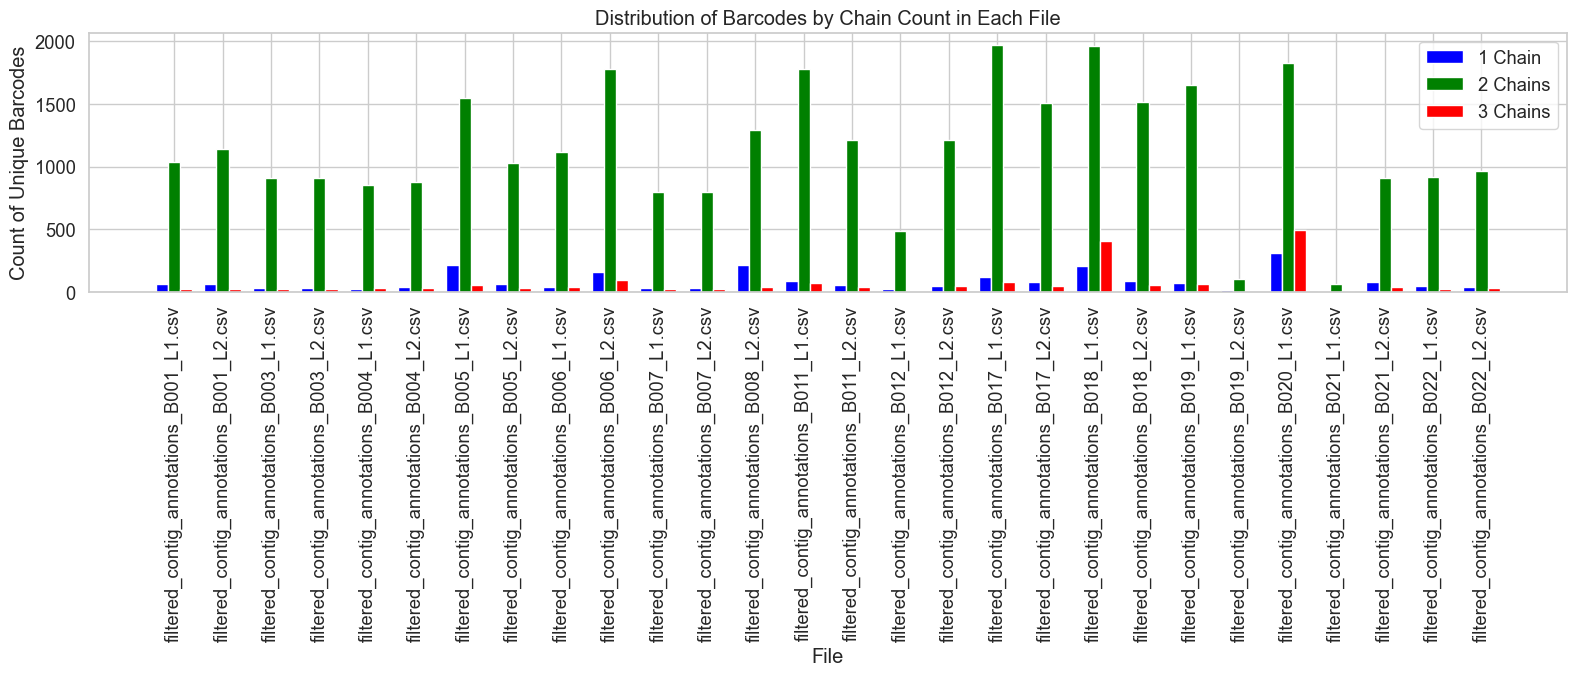

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
from collections import defaultdict

bcr_files = glob.glob("filtered_contig_annotations_B*_L*.csv")
chain_counts = defaultdict(lambda: {1: 0, 2: 0, 3: 0})

for file in bcr_files:
    df = pd.read_csv(file, dtype=str) 
    file_label = file.split("/")[-1]
    barcode_counts = df["barcode"].value_counts()
    
    for count in [1, 2, 3]:
        chain_counts[file_label][count] = (barcode_counts == count).sum()

summary_df = pd.DataFrame.from_dict(chain_counts, orient="index")
summary_df.columns = ["1_chain", "2_chains", "3_chains"]
summary_df = summary_df.sort_index()

import numpy as np

x = np.arange(len(summary_df))
width = 0.25

plt.figure(figsize=(16, 7))
plt.bar(x - width, summary_df["1_chain"], width, label="1 Chain", color="blue")
plt.bar(x, summary_df["2_chains"], width, label="2 Chains", color="green")
plt.bar(x + width, summary_df["3_chains"], width, label="3 Chains", color="red")

plt.xticks(ticks=x, labels=summary_df.index, rotation=90)
plt.xlabel("File")
plt.ylabel("Count of Unique Barcodes")
plt.title("Distribution of Barcodes by Chain Count in Each File")
plt.legend()
plt.tight_layout()
plt.show()


In [56]:
import pandas as pd

filtered_df.columns = filtered_df.columns.str.strip()
b_like_cells_df = filtered_df[filtered_df["Annotation_Level_1"].isin(["B", "Plasma B"])]

subtype_counts = b_like_cells_df.groupby("Annotation_Level_2")["barcode"].nunique().reset_index()
subtype_counts.columns = ["B_cell_subtype", "Unique_B_cells"]

target_subtypes = ["Plasma B NA", "B atypical", "B naive", "B memory"]
filtered_counts = subtype_counts[subtype_counts["B_cell_subtype"].isin(target_subtypes)]

print(filtered_counts)

  B_cell_subtype  Unique_B_cells
0     B atypical             919
1       B memory            4234
2        B naive            3894
3    Plasma B NA              72


In [58]:
import pandas as pd

filtered_df.columns = filtered_df.columns.str.strip()
b_like_cells_df = filtered_df[filtered_df["Annotation_Level_1"].isin(["B", "Plasma B"])].copy()

target_subtypes = ["Plasma B NA", "B atypical", "B naive", "B memory"]

healthy_df = b_like_cells_df[b_like_cells_df["T2D"] == "0"]
t2d_df = b_like_cells_df[b_like_cells_df["T2D"] == "1"]

def count_subtypes(df, label):
    subtype_counts = df.groupby("Annotation_Level_2")["barcode"].nunique().reset_index()
    subtype_counts.columns = ["B_cell_subtype", f"Unique_B_cells_{label}"]
    return subtype_counts[subtype_counts["B_cell_subtype"].isin(target_subtypes)]

healthy_counts = count_subtypes(healthy_df, "Healthy")
t2d_counts = count_subtypes(t2d_df, "T2D")

merged_counts = pd.merge(healthy_counts, t2d_counts, on="B_cell_subtype", how="outer").fillna(0)
merged_counts[["Unique_B_cells_Healthy", "Unique_B_cells_T2D"]] = merged_counts[["Unique_B_cells_Healthy", "Unique_B_cells_T2D"]].astype(int)

print(merged_counts)


  B_cell_subtype  Unique_B_cells_Healthy  Unique_B_cells_T2D
0     B atypical                     616                 303
1       B memory                    3054                1180
2        B naive                    2489                1405
3    Plasma B NA                      56                  16


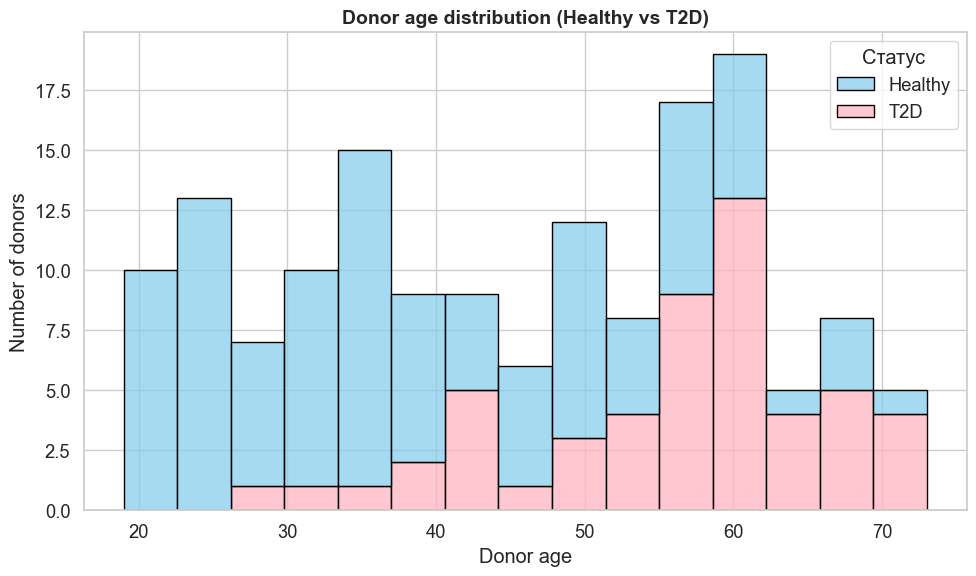

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

donors_age = filtered_df[["Genotyping_ID", "age", "T2D"]].drop_duplicates()
donors_age = donors_age[donors_age["age"].notna() & donors_age["T2D"].notna()].copy()
donors_age["age"] = donors_age["age"].astype(float)
donors_age["T2D"] = donors_age["T2D"].astype(int)
donors_age["Статус"] = donors_age["T2D"].map({0: "Healthy", 1: "T2D"})

sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(10, 6))

sns.histplot(data=donors_age, x="age", hue="Статус", bins=15, multiple="stack",
             palette={"Healthy": "skyblue", "T2D": "lightpink"}, edgecolor="black")

plt.xlabel("Donor age")
plt.ylabel("Number of donors")
plt.title("Donor age distribution (Healthy vs T2D)", fontsize=14, weight="bold")
plt.tight_layout()
plt.show()


Уникальных B-клеток (barcode): 52039


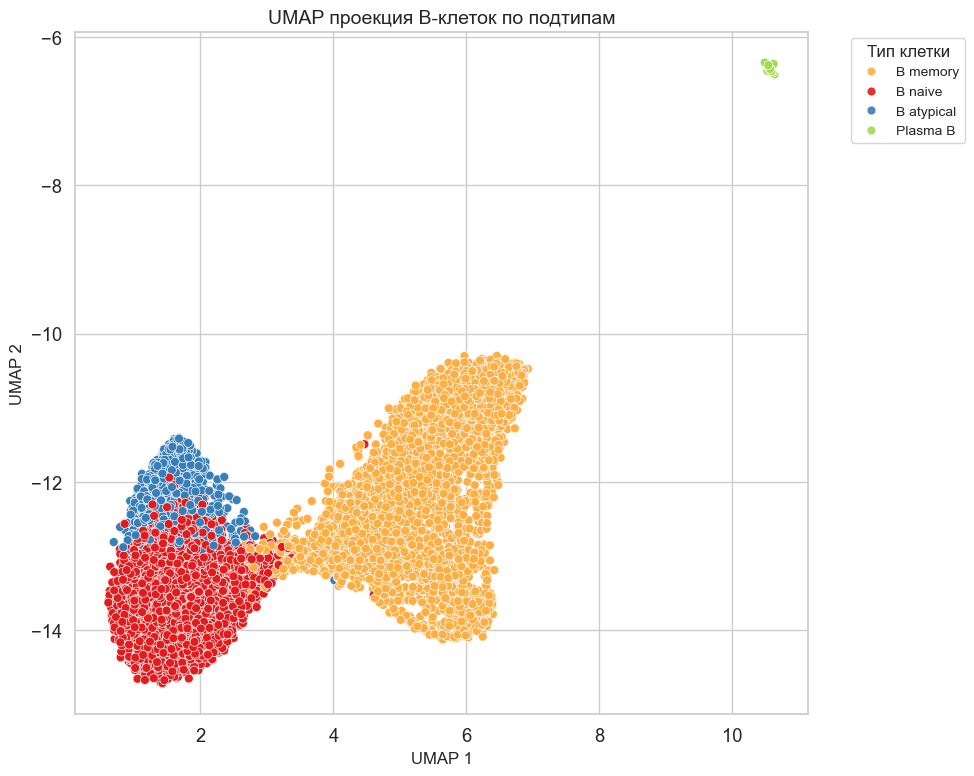

In [128]:
umap_df = filtered_df.dropna(subset=["UMAP_X", "UMAP_Y", "Annotation_Level_2"]).copy()
umap_df["UMAP_X"] = umap_df["UMAP_X"].astype(float)
umap_df["UMAP_Y"] = umap_df["UMAP_Y"].astype(float)

custom_palette = {
    "B atypical": "#377eb8",
    "B naive": "#e41a1c",     
    "B memory": "#ffae42",    
    "Plasma B": "#a6d854",      
    "Plasma B NA": "#a6d854"     
}

umap_df["Annotation_Level_2"] = umap_df["Annotation_Level_2"].replace("Plasma B NA", "Plasma B")

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df,
    x="UMAP_X",
    y="UMAP_Y",
    hue="Annotation_Level_2",
    palette=custom_palette,
    s=40,
    edgecolor="white",       # ← белая граница
    linewidth=0.4,
    alpha=0.9
)
plt.title("UMAP проекция B-клеток по подтипам", fontsize=14)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.legend(title="Тип клетки", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Уникальных B-клеток (barcode): 52039


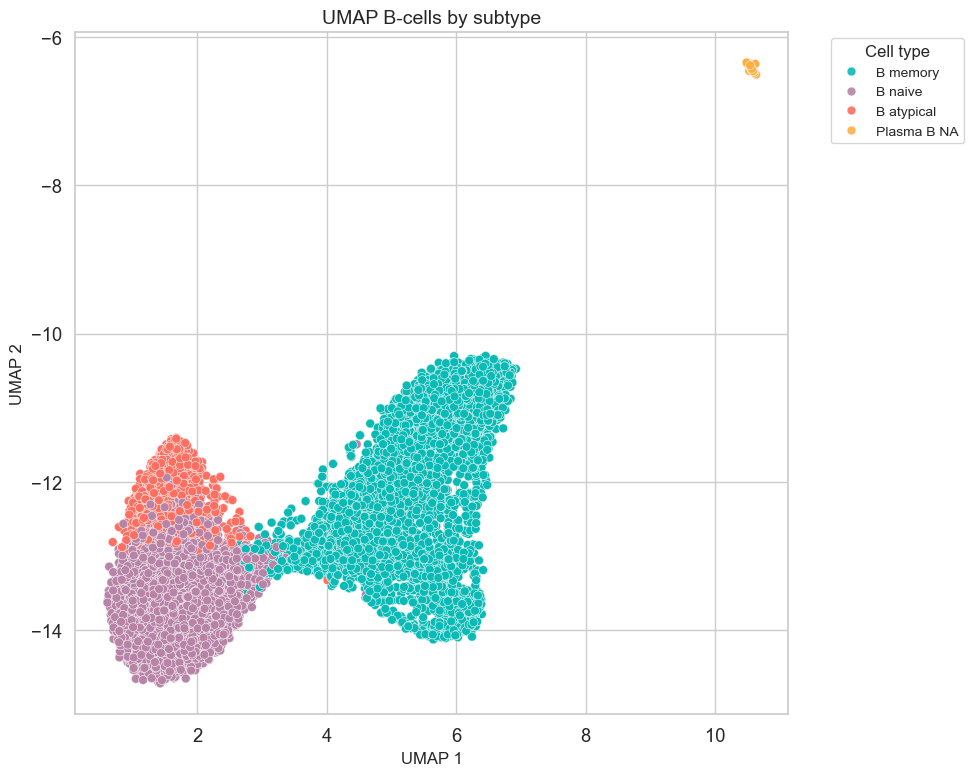

In [146]:
umap_df = filtered_df.dropna(subset=["UMAP_X", "UMAP_Y", "Annotation_Level_2"]).copy()
umap_df["UMAP_X"] = umap_df["UMAP_X"].astype(float)
umap_df["UMAP_Y"] = umap_df["UMAP_Y"].astype(float)


custom_palette = {
    "B atypical": "#FF6F61",
    "B naive": "#B784A7",      
    "B memory": "#0ABAB5",     
    "Plasma B NA": "#ffae42"     
}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df,
    x="UMAP_X",
    y="UMAP_Y",
    hue="Annotation_Level_2",
    palette=custom_palette,
    s=40,
    edgecolor="white",
    linewidth=0.3,
    alpha=0.9
)
plt.title("UMAP B-cells by subtype", fontsize=14)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.legend(title="Cell type", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


Уникальных B-клеток (barcode): 52039


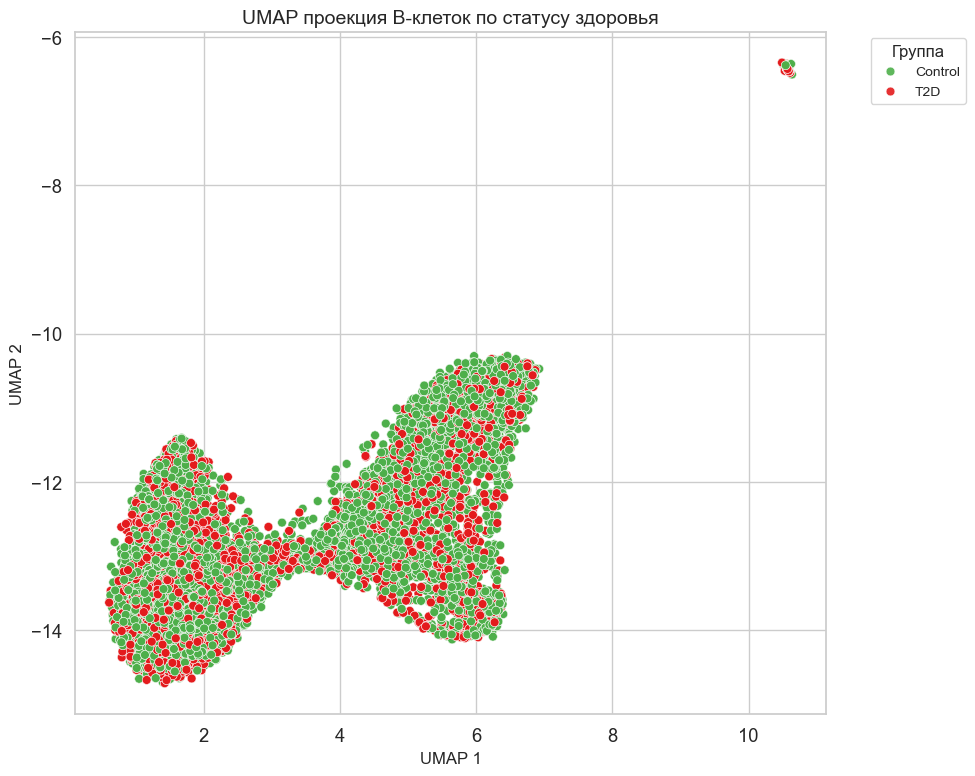

In [148]:
umap_df = filtered_df.dropna(subset=["UMAP_X", "UMAP_Y", "Group"]).copy()
umap_df["UMAP_X"] = umap_df["UMAP_X"].astype(float)
umap_df["UMAP_Y"] = umap_df["UMAP_Y"].astype(float)

group_palette = {
    "Control": "#4daf4a",  
    "T2D": "#e41a1c"      
}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=umap_df,
    x="UMAP_X",
    y="UMAP_Y",
    hue="Group",
    palette=group_palette,
    s=40,
    edgecolor="white",
    linewidth=0.4,
    alpha=0.9
)
plt.title("UMAP проекция B-клеток по статусу здоровья", fontsize=14)
plt.xlabel("UMAP 1", fontsize=12)
plt.ylabel("UMAP 2", fontsize=12)
plt.legend(title="Группа", title_fontsize=12, fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
